# Probablistic linear models using Pyro
August George, 2024, PNNL

## Linear regression

$y_i = m_i*x_i + b_i$

In [ ]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoNormal


pyro.set_rng_seed(42)

In [ ]:
# simulate the data
true_intercept = 1
true_slope = 2
num_data_points = 100  
X_values = torch.linspace(0, 1, num_data_points)
Y_values = true_intercept + true_slope * X_values 
Y_obs_values = Y_values + torch.randn(num_data_points) 


plt.scatter(X_values, Y_obs_values, label=r'$Y_{obs} = Y_{true} + \epsilon$, $\epsilon \sim \text{Norm}(0,1)$')
plt.plot(X_values, Y_values, color='red', label=r'$Y_{true}$')
plt.ylabel('Y')
plt.xlabel('X')
plt.legend()
plt.show()

## Bayesian inference using NUTS

In [ ]:
def linear_model(X_values, Y_values):
    intercept_prior = pyro.sample('intercept', dist.Normal(0, 10))
    slope_prior = pyro.sample('slope', dist.Normal(0, 10))
    noise_std_prior = pyro.sample('noise_std', dist.LogNormal(0, 1)) 
    mean_prediction = intercept_prior + slope_prior * X_values
    with pyro.plate('data', len(X_values)):
        pyro.sample('observations', dist.Normal(mean_prediction, noise_std_prior), obs=Y_values)

# MCMC inference
nuts_kernel = NUTS(linear_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(X_values, Y_obs_values)
posterior_samples = mcmc.get_samples()

In [ ]:
intercept_samples = posterior_samples["intercept"]
slope_samples = posterior_samples["slope"]
noise_std_samples = posterior_samples["noise_std"]
prior_intercept_samples = dist.Normal(0, 10).sample([1000])
prior_slope_samples = dist.Normal(0, 10).sample([1000])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.kdeplot(prior_intercept_samples.numpy(), fill=True, color='blue', label='Prior Intercept', ax=axs[0])
sns.kdeplot(intercept_samples.numpy(), fill=True, color='orange', label='Posterior Intercept', ax=axs[0])
axs[0].set_title('Prior and Posterior Distribution of Intercept')
axs[0].set_xlabel('Intercept')
axs[0].set_ylabel('Density')
axs[0].legend()
sns.kdeplot(prior_slope_samples.numpy(), fill=True, color='green', label='Prior Slope', ax=axs[1])
sns.kdeplot(slope_samples.numpy(), fill=True, color='red', label='Posterior Slope', ax=axs[1])
axs[1].set_title('Prior and Posterior Distribution of Slope')
axs[1].set_xlabel('Slope')
axs[1].set_ylabel('Density')
axs[1].legend()
plt.tight_layout()
plt.show()

az.plot_trace({"intercept": intercept_samples, "slope": slope_samples})
plt.show()

intercept_mean = intercept_samples.mean().item()
intercept_std = intercept_samples.std().item()
slope_mean = slope_samples.mean().item()
slope_std = slope_samples.std().item()
noise_std_mean = noise_std_samples.mean().item()
noise_std_std = noise_std_samples.std().item()

display(f"MCMC intercept_mean = {intercept_mean}, intercept_std = {intercept_std}")
display(f"MCMC SVI slope_mean = {slope_mean}, slope_std = {slope_std}")

## Variational inference

In [ ]:
def linear_model_guide(X_values, Y_values):
    intercept_loc = pyro.param('intercept_loc', torch.tensor(0.0))
    intercept_scale = pyro.param('intercept_scale', torch.tensor(1.0), constraint=torch.distributions.constraints.positive)
    slope_loc = pyro.param('slope_loc', torch.tensor(0.0))
    slope_scale = pyro.param('slope_scale', torch.tensor(1.0), constraint=torch.distributions.constraints.positive)
    noise_std_loc = pyro.param('noise_std_loc', torch.tensor(0.0))
    noise_std_scale = pyro.param('noise_std_scale', torch.tensor(1.0), constraint=torch.distributions.constraints.positive)
    pyro.sample('intercept', dist.Normal(intercept_loc, intercept_scale))
    pyro.sample('slope', dist.Normal(slope_loc, slope_scale))
    pyro.sample('noise_std', dist.LogNormal(noise_std_loc, noise_std_scale))


optimizer = optim.Adam({"lr": 0.01})
svi_manual = SVI(linear_model, linear_model_guide, optimizer, loss=Trace_ELBO())
num_iterations = 1000
elbo_values = []  
for step in range(num_iterations):
    loss = svi_manual.step(X_values, Y_values)
    elbo_values.append(loss)
    if step % 100 == 0:
        print(f"Manual SVI Step {step} : loss = {loss}")

intercept_loc = pyro.param('intercept_loc').item()
intercept_scale = pyro.param('intercept_scale').item()
slope_loc = pyro.param('slope_loc').item()
slope_scale = pyro.param('slope_scale').item()
noise_std_loc = torch.tensor(pyro.param('noise_std_loc'))  # Convert to tensor
noise_std_scale = torch.tensor(pyro.param('noise_std_scale'))  
noise_std_exp = torch.exp(noise_std_loc).item()

prior_intercept_samples = dist.Normal(0, 10).sample([1000]).numpy()
prior_slope_samples = dist.Normal(0, 10).sample([1000]).numpy()
intercept_samples = dist.Normal(intercept_loc, intercept_scale).sample([1000]).numpy()
slope_samples = dist.Normal(slope_loc, slope_scale).sample([1000]).numpy()

plt.figure(figsize=(10, 6))
plt.plot(elbo_values)
plt.xlabel('Iteration')
plt.ylabel('ELBO (loss)')
plt.title('ELBO Plot for Manual SVI')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(18, 5))
sns.kdeplot(prior_intercept_samples, fill=True, color='blue', label='Prior Intercept', ax=axs[0])
sns.kdeplot(intercept_samples, fill=True, color='orange', label='Posterior Intercept', ax=axs[0])
axs[0].set_title('Prior and Posterior Distribution of Intercept')
axs[0].set_xlabel('Intercept')
axs[0].set_ylabel('Density')
axs[0].legend()

sns.kdeplot(prior_slope_samples, fill=True, color='green', label='Prior Slope', ax=axs[1])
sns.kdeplot(slope_samples, fill=True, color='orange', label='Posterior Slope', ax=axs[1])
axs[1].set_title('Prior and Posterior Distribution of Slope')
axs[1].set_xlabel('Slope')
axs[1].set_ylabel('Density')
axs[1].legend()
plt.tight_layout()
plt.show()


display(f"Manual SVI intercept_mean = {intercept_loc}, intercept_std = {intercept_scale}")
display(f"Manual SVI slope_mean = {slope_loc}, slope_std = {slope_scale}")

## Variational inference using an autoguide

In [ ]:
auto_guide = AutoNormal(linear_model)
optimizer = optim.Adam({"lr": 0.01})
svi = SVI(linear_model, auto_guide, optimizer, loss=Trace_ELBO())

num_iterations = 1000
elbo_values = []  
for step in range(num_iterations):
    loss = svi.step(X_values, Y_values)
    elbo_values.append(loss)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

# get samples
prior_intercept_samples = dist.Normal(0, 10).sample([1000]).numpy()
prior_slope_samples = dist.Normal(0, 10).sample([1000]).numpy()
posterior_samples = [auto_guide() for _ in range(1000)]
posterior_samples = {k: torch.stack([s[k] for s in posterior_samples]) for k in posterior_samples[0]}
intercept_samples = posterior_samples['intercept'].detach().numpy()
slope_samples = posterior_samples['slope'].detach().numpy()
noise_std_samples = torch.exp(posterior_samples['noise_std']).detach().numpy()
intercept_mean = intercept_samples.mean()
intercept_std = intercept_samples.std()
slope_mean = slope_samples.mean()
slope_std = slope_samples.std()
noise_std_mean = noise_std_samples.mean()
noise_std_std = noise_std_samples.std()

# plot
plt.figure(figsize=(10, 6))
plt.plot(elbo_values)
plt.xlabel('Iteration')
plt.ylabel('ELBO (loss)')
plt.title('ELBO Plot for Auto SVI')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(18, 5))
sns.kdeplot(prior_intercept_samples, fill=True, color='blue', label='Prior Intercept', ax=axs[0])
sns.kdeplot(intercept_samples, fill=True, color='orange', label='Posterior Intercept', ax=axs[0])
axs[0].set_title('Prior and Posterior Distribution of Intercept')
axs[0].set_xlabel('Intercept')
axs[0].set_ylabel('Density')
axs[0].legend()

sns.kdeplot(prior_slope_samples, fill=True, color='green', label='Prior Slope', ax=axs[1])
sns.kdeplot(slope_samples, fill=True, color='orange', label='Posterior Slope', ax=axs[1])
axs[1].set_title('Prior and Posterior Distribution of Slope')
axs[1].set_xlabel('Slope')
axs[1].set_ylabel('Density')
axs[1].legend()

plt.tight_layout()
plt.show()

display(f"Auto SVI intercept_mean = {intercept_mean}, intercept_std = {intercept_std}")
display(f"Auto SVI slope_mean = {slope_mean}, slope_std = {slope_std}")
display(f"Auto SVI noise_std_mean = {noise_std_mean}, noise_std_std = {noise_std_std}")


## linear structural causal model from gene regulatory network

A --> B

B --> C

D --| B

In [ ]:
# Number of samples
num_samples = 100

# Ground truth parameters
true_beta_A_B = 2.0
true_beta_D_B = -1.0
true_beta_B_C = 1.5

# Generate synthetic data
epsilon_A = torch.normal(0, 1, (num_samples,))
epsilon_B = torch.normal(0, 1, (num_samples,))
epsilon_C = torch.normal(0, 1, (num_samples,))
epsilon_D = torch.normal(0, 1, (num_samples,))

A = epsilon_A
D = epsilon_D
B = true_beta_A_B * A + true_beta_D_B * D + epsilon_B
C = true_beta_B_C * B + epsilon_C


# Print first few samples for inspection
display('Synthetic Data (first 5 samples):')
display('A =', A[:5])
display('B =', B[:5])
display('C =', C[:5])
display('D =', D[:5])


In [ ]:
def gene_network_model(A, B, C, D, num_samples):
    # Priors for parameters
    beta_A_B = pyro.sample('beta_A_B', dist.Normal(0, 1))
    beta_D_B = pyro.sample('beta_D_B', dist.Normal(0, 1))
    beta_B_C = pyro.sample('beta_B_C', dist.Normal(0, 1))
    
    # Priors for epsilon (noise terms)
    epsilon_A = pyro.sample('epsilon_A', dist.Normal(0, 1).expand([num_samples]).to_event(1))
    epsilon_B = pyro.sample('epsilon_B', dist.Normal(0, 1).expand([num_samples]).to_event(1))
    epsilon_C = pyro.sample('epsilon_C', dist.Normal(0, 1).expand([num_samples]).to_event(1))
    epsilon_D = pyro.sample('epsilon_D', dist.Normal(0, 1).expand([num_samples]).to_event(1))
    
    # Structural equations with uncertainty (noise terms)

    # use determinstic to represent 
    A_model = epsilon_A
    D_model = epsilon_D
    B_model = beta_A_B * A_model + beta_D_B * D_model + epsilon_B
    C_model = beta_B_C * B_model + epsilon_C
    
    
    # Define likelihoods for observed (real) data
    with pyro.plate('data', num_samples):
        pyro.sample('obs_A', dist.Normal(A_model, 1), obs=A)
        pyro.sample('obs_B', dist.Normal(B_model, 1), obs=B)
        pyro.sample('obs_C', dist.Normal(C_model, 1), obs=C)
        pyro.sample('obs_D', dist.Normal(D_model, 1), obs=D)

In [ ]:
pyro.render_model(gene_network_model, model_args=(A,  B, C, D, num_samples), render_distributions=True)

In [ ]:
import pyro.infer.mcmc as mcmc
import pyro.infer.mcmc.api as mcmc_api

pyro.set_rng_seed(42)

# Perform MCMC inference
pyro.clear_param_store()
kernel = mcmc_api.NUTS(lambda A,  B, C, D: gene_network_model(A,  B, C, D, num_samples), adapt_step_size=True)
mcmc_run = mcmc_api.MCMC(kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmc_run.run(A, B, C, D)

# Extract samples
mcmc_samples = mcmc_run.get_samples()

# Prior samples for comparison
prior_sample_size = 1000
prior_beta_A_B = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()
prior_beta_D_B = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()
prior_beta_B_C = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()

# Posterior samples
posterior_beta_A_B = mcmc_samples['beta_A_B'].detach().numpy()
posterior_beta_D_B = mcmc_samples['beta_D_B'].detach().numpy()
posterior_beta_B_C = mcmc_samples['beta_B_C'].detach().numpy()

# Plot KDEs
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.kdeplot(prior_beta_A_B, fill=True, color='blue', label='Prior Beta_A_B', ax=axs[0])
sns.kdeplot(posterior_beta_A_B, fill=True, color='orange', label='Posterior Beta_A_B', ax=axs[0])
axs[0].axvline(true_beta_A_B, color='black', linestyle='dashed', linewidth=1, label='True Beta_A_B')
axs[0].set_title('Prior and Posterior Distribution of Beta_A_B')
axs[0].set_xlabel('Beta_A_B')
axs[0].set_ylabel('Density')
axs[0].legend()

sns.kdeplot(prior_beta_D_B, fill=True, color='blue', label='Prior Beta_D_B', ax=axs[1])
sns.kdeplot(posterior_beta_D_B, fill=True, color='orange', label='Posterior Beta_D_B', ax=axs[1])
axs[1].axvline(true_beta_D_B, color='black', linestyle='dashed', linewidth=1, label='True Beta_D_B')
axs[1].set_title('Prior and Posterior Distribution of Beta_D_B')
axs[1].set_xlabel('Beta_D_B')
axs[1].set_ylabel('Density')
axs[1].legend()

sns.kdeplot(prior_beta_B_C, fill=True, color='blue', label='Prior Beta_B_C', ax=axs[2])
sns.kdeplot(posterior_beta_B_C, fill=True, color='orange', label='Posterior Beta_B_C', ax=axs[2])
axs[2].axvline(true_beta_B_C, color='black', linestyle='dashed', linewidth=1, label='True Beta_B_C')
axs[2].set_title('Prior and Posterior Distribution of Beta_B_C')
axs[2].set_xlabel('Beta_B_C')
axs[2].set_ylabel('Density')
axs[2].legend()

plt.tight_layout()
plt.show()


## SVI 

In [ ]:
# Define the guide
guide = AutoNormal(gene_network_model)

# Set up the optimizer
optimizer = pyro.optim.Adam({"lr": 0.01})

# Set up the SVI object
svi = SVI(gene_network_model, guide, optimizer, loss=Trace_ELBO())

# Number of training steps
num_steps = 10000

# Run SVI
pyro.clear_param_store()
for step in range(num_steps):
    svi.step(A,  B, C, D, num_samples)
    if step % 500 == 0:
        elbo = svi.evaluate_loss(A, B, C,  D, num_samples)
        print(f'Step {step} - ELBO: {elbo}')


In [ ]:
from pyro.infer import SVI, Trace_ELBO, Predictive

# Use Predictive to get posterior samples
predictive = Predictive(guide, num_samples=1000)
posterior_samples = predictive(A,  B, C, D, num_samples)
posterior_beta_A_B = posterior_samples['beta_A_B'].detach().numpy()
posterior_beta_D_B = posterior_samples['beta_D_B'].detach().numpy()
posterior_beta_B_C = posterior_samples['beta_B_C'].detach().numpy()

# Prior samples for comparison
prior_sample_size = 1000
prior_beta_A_B = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()
prior_beta_D_B = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()
prior_beta_B_C = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()

# Plot KDEs
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.kdeplot(prior_beta_A_B, fill=True, color='blue', label='Prior Beta_A_B', ax=axs[0])
sns.kdeplot(posterior_beta_A_B, fill=True, color='orange', label='Posterior Beta_A_B', ax=axs[0])
axs[0].axvline(true_beta_A_B, color='black', linestyle='dashed', linewidth=1, label='True Beta_A_B')
axs[0].set_title('Prior and Posterior Distribution of Beta_A_B')
axs[0].set_xlabel('Beta_A_B')
axs[0].set_ylabel('Density')
axs[0].legend()

sns.kdeplot(prior_beta_D_B, fill=True, color='blue', label='Prior Beta_D_B', ax=axs[1])
sns.kdeplot(posterior_beta_D_B, fill=True, color='orange', label='Posterior Beta_D_B', ax=axs[1])
axs[1].axvline(true_beta_D_B, color='black', linestyle='dashed', linewidth=1, label='True Beta_D_B')
axs[1].set_title('Prior and Posterior Distribution of Beta_D_B')
axs[1].set_xlabel('Beta_D_B')
axs[1].set_ylabel('Density')
axs[1].legend()

sns.kdeplot(prior_beta_B_C, fill=True, color='blue', label='Prior Beta_B_C', ax=axs[2])
sns.kdeplot(posterior_beta_B_C, fill=True, color='orange', label='Posterior Beta_B_C', ax=axs[2])
axs[2].axvline(true_beta_B_C, color='black', linestyle='dashed', linewidth=1, label='True Beta_B_C')
axs[2].set_title('Prior and Posterior Distribution of Beta_B_C')
axs[2].set_xlabel('Beta_B_C')
axs[2].set_ylabel('Density')
axs[2].legend()

plt.tight_layout()
plt.show()


## SVI with multinormal

In [ ]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal, AutoNormalizingFlow, AutoLowRankMultivariateNormal
from pyro.distributions.transforms import AffineAutoregressive
import pyro.optim  # Ensure that Pyro's optim module is imported
from pyro.optim import Adam, PyroLRScheduler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

pyro.set_rng_seed(40)

# Define the guide
guide = AutoMultivariateNormal(gene_network_model)
#guide = AutoNormal(gene_network_model)


# # Set up the optimizer
# adam_params = {"lr": 0.001}
# scheduler_params = {
#     "optimizer": torch.optim.Adam,
#     "optim_args": adam_params,
#     "step_size": 5000,  
#     "gamma": 0.3  
# }
# scheduler = pyro.optim.StepLR(scheduler_params)

scheduler =  Adam({"lr": 0.001})  # Use a constant learning rate

# Set up the SVI object
svi = SVI(gene_network_model, guide, scheduler, loss=Trace_ELBO())

# Number of training steps
num_steps = 2000

# Run SVI with progress bar
pyro.clear_param_store()
elbos = []
with tqdm(total=num_steps, desc="SVI Training Progress") as pbar:
    for step in range(num_steps):
        elbo = svi.step(A,B, C,  D, num_samples)
        elbos.append(elbo)
        if step % 100 == 0:
            pbar.set_postfix(ELBO=elbo)
        pbar.update(1)


# Plot ELBOs
plt.figure(figsize=(10, 5))
plt.plot(elbos)
plt.xlabel('Step')
plt.ylabel('ELBO')
plt.title('ELBO over Time')
plt.show()

# Posterior predictive checks
predictive = Predictive(guide, num_samples=1000)
posterior_samples = predictive(A=A, B=B, C=C, D=D, num_samples=num_samples)

posterior_beta_A_B = posterior_samples['beta_A_B'].detach().numpy().flatten()
posterior_beta_D_B = posterior_samples['beta_D_B'].detach().numpy().flatten()
posterior_beta_B_C = posterior_samples['beta_B_C'].detach().numpy().flatten()

# Prior samples for comparison
prior_sample_size = 1000
prior_beta_A_B = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()
prior_beta_D_B = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()
prior_beta_B_C = dist.Normal(0, 1).sample([prior_sample_size]).detach().numpy()

# Plot KDEs
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.kdeplot(prior_beta_A_B, fill=True, color='blue', label='Prior Beta_A_B', ax=axs[0])
sns.kdeplot(posterior_beta_A_B, fill=True, color='orange', label='Posterior Beta_A_B', ax=axs[0])
axs[0].axvline(true_beta_A_B, color='black', linestyle='dashed', linewidth=1, label='True Beta_A_B')
axs[0].set_title('Prior and Posterior Distribution of Beta_A_B')
axs[0].set_xlabel('Beta_A_B')
axs[0].set_ylabel('Density')
axs[0].legend()

sns.kdeplot(prior_beta_D_B, fill=True, color='blue', label='Prior Beta_D_B', ax=axs[1])
sns.kdeplot(posterior_beta_D_B, fill=True, color='orange', label='Posterior Beta_D_B', ax=axs[1])
axs[1].axvline(true_beta_D_B, color='black', linestyle='dashed', linewidth=1, label='True Beta_D_B')
axs[1].set_title('Prior and Posterior Distribution of Beta_D_B')
axs[1].set_xlabel('Beta_D_B')
axs[1].set_ylabel('Density')
axs[1].legend()

sns.kdeplot(prior_beta_B_C, fill=True, color='blue', label='Prior Beta_B_C', ax=axs[2])
sns.kdeplot(posterior_beta_B_C, fill=True, color='orange', label='Posterior Beta_B_C', ax=axs[2])
axs[2].axvline(true_beta_B_C, color='black', linestyle='dashed', linewidth=1, label='True Beta_B_C')
axs[2].set_title('Prior and Posterior Distribution of Beta_B_C')
axs[2].set_xlabel('Beta_B_C')
axs[2].set_ylabel('Density')
axs[2].legend()

plt.tight_layout()
plt.show()

# Adding technical noise to the model

# Making a pyro module

Goal: use a simple linear model to validate a probablistic model for biological and observational processes.

### The biological process model
$A$ regulates $B$ (A-->B), which is represented with a linear model: $A = \epsilon_A$ and $B = \beta_{AB}A + \epsilon_B$.

$\epsilon_A$ and $\epsilon_B$ represent biological noise and are sampled from Normal(0,1).

$\beta_{AB}$ represents the strength of the regulation between $A$ and $B$.

### The observational model
Our observations are not from the biological model directly, but include technical noise from the experiment. 

The observed gene expression values are a function of the biological and observational/technical processes: 
$A_{obs} = f(A, \theta_{bio}^A, \theta_{obs}^A)$ and 
$B_{obs} = f(B, \theta_{bio}^B, \theta_{obs}^B)$




In [ ]:
import pyro
import pyro.distributions as dist
import torch
from pyro.nn import PyroModule, PyroSample, PyroParam

class BiologicalProcess(PyroModule):
    def __init__(self, num_samples=100, beta_AB_true=2):
        super().__init__()
        self.num_samples = num_samples
        self.register_buffer('beta_AB_true',torch.tensor(beta_AB_true) )

    @PyroSample
    def epsilon_A(self):
        return dist.Normal(0, 1).expand([self.num_samples]).to_event(1)

    @PyroSample
    def epsilon_B(self):
        return dist.Normal(0, 1).expand([self.num_samples]).to_event(1)

    @PyroSample
    def beta_AB(self):
        return dist.Normal(0, 1).expand([self.num_samples]).to_event(1)

    def forward(self):
        A_bio = pyro.deterministic('A_bio', torch.clamp(self.epsilon_A, min=0))
        B_bio = pyro.deterministic('B_bio', torch.clamp(self.beta_AB * A_bio + self.epsilon_B, min=0))
        return A_bio, B_bio


class TechnicalNoiseProcess(PyroModule):
    def __init__(self, biological_model, k=1, q=0.5, epsilon=1e-8):
        super().__init__()
        self.biological_model = biological_model
        self.register_buffer("k", torch.tensor(k))  
        self.register_buffer("q", torch.tensor(q))  
        self.register_buffer("eps", torch.tensor(epsilon))  

    def forward(self, A_obs=torch.as_tensor(1.0), B_obs=torch.as_tensor(1.0), return_generated=False):
        A_bio, B_bio = self.biological_model()

        A_obs_mask = ~A_obs.isnan()
        B_obs_mask = ~B_obs.isnan()

        with pyro.plate('data', self.biological_model.num_samples):

            A_UMI_obs = pyro.sample('A_UMI_obs', dist.Poisson(A_bio+self.eps), obs=A_obs, obs_mask=A_obs_mask)
            B_UMI_obs = pyro.sample('B_UMI_obs', dist.Poisson(B_bio+self.eps), obs=B_obs, obs_mask=B_obs_mask)

        if return_generated:
            return A_UMI_obs, B_UMI_obs

# Instantiate and run the technical noise process model with the biological model
biological_model = BiologicalProcess(num_samples=100)
pyro.render_model(biological_model, render_distributions=True, render_deterministic=True)


In [ ]:
technical_noise_process = TechnicalNoiseProcess(biological_model)
pyro.render_model(technical_noise_process, render_distributions=True, render_deterministic=True)

In [ ]:
# get samples 
beta_AB_true = biological_model.beta_AB_true.detach().cpu().numpy()
A_obs_tensor, B_obs_tensor = technical_noise_process(return_generated=True)
A_obs = A_obs_tensor.detach()
B_obs = B_obs_tensor.detach()

display(A_obs[:100])
display(B_obs[:100])

In [ ]:
import pyro.poutine as poutine
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal

beta_AB_true = biological_model.beta_AB_true.detach().cpu().numpy()
A_obs_tensor, B_obs_tensor = technical_noise_process.forward(return_generated=True)
A_obs = A_obs_tensor.detach()
B_obs = B_obs_tensor.detach()

display(f'True beta_AB: {beta_AB_true}')
display(type(A_obs))


# Define the model to be used for inference
def model(A_obs, B_obs):
    biological_model = BiologicalProcess(num_samples=100)
    technical_model = TechnicalNoiseProcess(biological_model)
    technical_model.forward(A_obs=A_obs, B_obs=B_obs)

# Define a guide that allows enumeration of discrete variables
guide = AutoMultivariateNormal(poutine.block(model, hide=['dropout_binary_indicator_A', 'dropout_binary_indicator_B']))

# Use TraceEnum_ELBO to handle discrete enumeration
optimizer = pyro.optim.Adam({"lr": 0.01})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

svi = SVI(model, guide, optimizer, loss=elbo)

# Run SVI
num_steps = 2000
losses = []
for step in range(num_steps):
    loss = svi.step(A_obs, B_obs)
    losses.append(loss)
    if step % 500 == 0:
        print(f"Step {step} : loss = {loss}")
        
# Plot the loss curve
plt.plot(losses)
plt.xlabel('SVI step')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

# Extract learned parameters from the AutoGuide
posterior_samples = guide.get_posterior().sample((1000,))

# Generate prior samples for beta_AB
prior_samples = dist.Normal(0, 1).sample((1000,)).numpy()

# Plot the results
plt.figure(figsize=(10, 6))
plt.hist(posterior_samples.flatten(), bins=30, density=True, alpha=0.6, color='k', label='Learned beta_AB posterior')
plt.hist(prior_samples, bins=30, density=True, alpha=0.6, color='b', label='Prior beta_AB')
plt.axvline(x=beta_AB_true, color='r', linestyle='--', label='True beta_AB')
plt.xlabel('beta_AB')
plt.ylabel('Density')
plt.title('Posterior and Prior Distribution of beta_AB')
plt.legend()
plt.show()

# generalized linear structural causal model 

$\vec{y} = \underset{n \times n}\Alpha\vec{x} + \vec{\epsilon}$

example $A\rightarrow B$:


$y_A = \epsilon_A$

$y_B = \alpha_{AB}\cdot A  + \epsilon_B$

$\vec{y} = [y_A, y_B]$

$\underset{2\times 2} \Alpha = \begin{bmatrix}0 & \alpha_{AB} \\ 0&0 \end{bmatrix}$

$\vec{\epsilon} = [\epsilon_A, \epsilon_B]$

In [ ]:
import networkx as nx

graph = nx.DiGraph()
graph.add_edge('A', 'B')
adj_matrix_dense = nx.adjacency_matrix(graph).toarray()
adj_matrix_dense


In [ ]:
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import torch
import networkx as nx

# Create a directed graph (DiGraph)
G = nx.DiGraph()
G.add_edge(0, 1)
G.add_edge(1, 2)
G.add_edge(2, 0)
G.add_edge(2, 3)

# Plot the visual graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=2000, edge_color='k', font_size=15, font_color='black', font_weight='bold')
plt.title('Graph Visualization')
plt.show()



# Get the adjacency matrix as a dense NumPy array
adj_matrix_dense = nx.adjacency_matrix(G).toarray()
display(adj_matrix_dense)


# Convert the dense NumPy array to a PyTorch sparse tensor
adj_matrix_dense = torch.tensor(adj_matrix_dense, dtype=torch.float32)
adj_matrix_sparse = adj_matrix_dense.to_sparse()
display(adj_matrix_sparse)


# Define a simple model using the sparse adjacency matrix
def model(adj_matrix_sparse):
    num_nodes = adj_matrix_sparse.size(0)
    for i in range(num_nodes):
        for j in range(num_nodes):
            if (adj_matrix_sparse._indices() == torch.tensor([[i], [j]])).all(dim=0).any():
                # Sample from a distribution for nonzero elements
                pyro.sample(f"alpha_{i}_{j}", dist.Normal(0, 1))




# Trace the model execution
trace = poutine.trace(model).get_trace(adj_matrix_sparse)

# Print the trace
for name, site in trace.nodes.items():
    if site["type"] == "sample":
        print(f"{name}: {site['value']}")

pyro.render_model(model, model_args=(adj_matrix_sparse,), render_distributions=True, render_deterministic=True)

'adjacency matrix: tensor([[0, 1, 0, 1],\n        [0, 0, 1, 0],\n        [0, 0, 0, 0],\n        [0, 0, 0, 0]])'

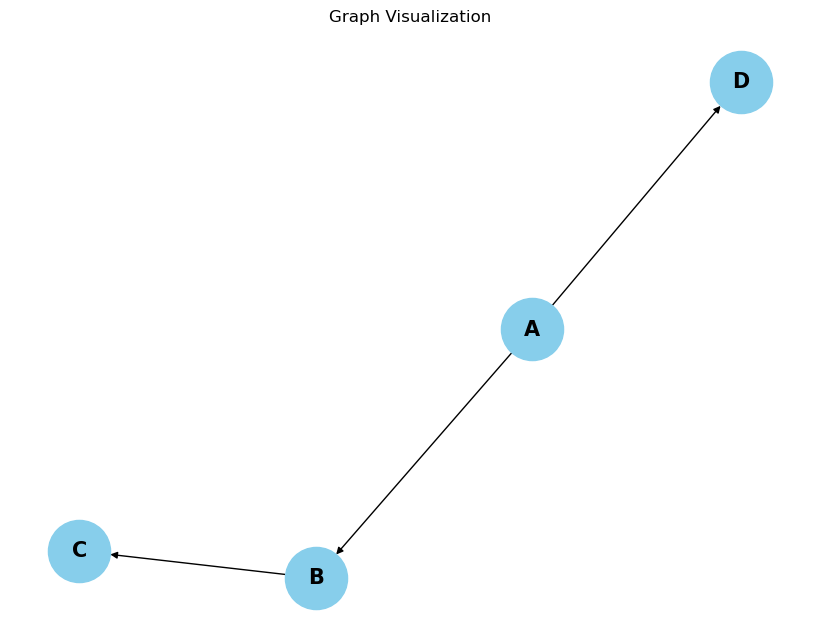

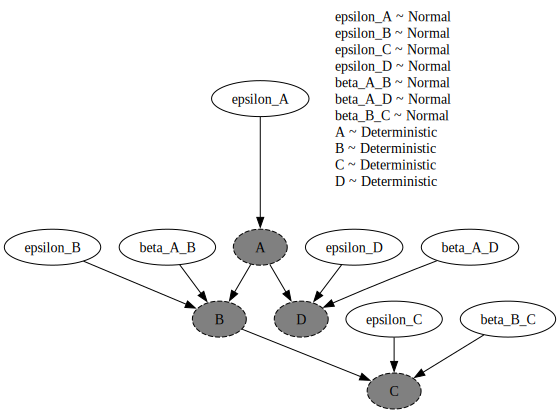

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import torch


def linear_structural_causal_model(adjacency_matrix, node_names):    
    # Initialize a dictionary to store the sampled values
    state_variables = {}
    
    # Sample noise for each state variable
    noise = {name: pyro.sample(f"epsilon_{name}", dist.Normal(0, 1)) for name in node_names}
    
    # Prior distributions for the beta parameters (relationship strengths)
    beta = {f"beta_{parent}_{child}": pyro.sample(f"beta_{parent}_{child}", dist.Normal(0, 1)) 
            for i, parent in enumerate(node_names) for j, child in enumerate(node_names) if adjacency_matrix[i][j] == 1}
    
    # Calculate the values of state variables based on their parents
    for j, child in enumerate(node_names):
        parent_sum = 0.0
        for i, parent in enumerate(node_names):
            if adjacency_matrix[i][j] == 1:
                parent_sum += beta[f"beta_{parent}_{child}"] * state_variables.get(parent, noise[parent])
        state_variables[child] = pyro.deterministic(child, parent_sum + noise[child])
    
    return state_variables



# Define the DAG using an adjacency matrix (A -> B -> C, A -> D)
adj_matrix = torch.tensor([[0, 1, 0, 1],  # A
                           [0, 0, 1, 0],  # B
                           [0, 0, 0, 0],  # C
                           [0, 0, 0, 0]]) # D

display(f"adjacency matrix: {adj_matrix}")

node_names = ['A', 'B', 'C', 'D']

# Create a directed graph (DiGraph)
G = nx.DiGraph()
G.add_edges_from([('A', 'B'), ('B', 'C'), ('A', 'D')])

# Plot the visual graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=2000, edge_color='k', font_size=15, font_color='black', font_weight='bold')
plt.title('Graph Visualization')
plt.show()

# Generate the probabilistic model
pyro.clear_param_store()  # Clear the parameter store
model = lambda: linear_structural_causal_model(adj_matrix, node_names)

# Visualize the model
pyro.render_model(model, render_distributions=True, render_deterministic=True, filename="LSCM_graph.png")






In [39]:
import pyro
import pyro.distributions as dist
import torch
import sympy as sy
import sympytorch

# # TODO: extra funcs argument in sympytorch.SymPyModule?
# def solve_lscm(sympy_symbol_params, sympy_lscm):
#     eqns = [sy.Eq(lhs.subs(sympy_symbol_params), rhs.subs(sympy_symbol_params)) for lhs, rhs in sympy_lscm.items()]   
#     sympy_out = sy.solve(eqns, list(sympy_lscm), rational=False)
    
#     return sympy_out

# solve_lscm(sympy_symbol_params, sympy_lscm)


# Define the LSCM symbols and equations
x, y, z, beta_xy, beta_yz, epsilon_x, epsilon_y, epsilon_z = sy.symbols('x y z beta_xy beta_yz epsilon_x epsilon_y epsilon_z')
sympy_lscm = {
    z: epsilon_z,
    y: beta_yz * z + epsilon_y,
    x: beta_xy * y + epsilon_x,
}

# networkx graph 
G = nx.DiGraph()
G.add_edge(z, y)
G.add_edge(y, x)
sorted_nodes = list(nx.topological_sort(G))
display(sorted_nodes)

[z, y, x]

In [47]:
substituted_nodes = []
for node in sorted_nodes:
    substituted_nodes.append(node.subs(node,sympy_lscm[node]))


print(sorted_nodes)
print(substituted_nodes)


[z, y, x]
[epsilon_z, beta_yz*z + epsilon_y, beta_xy*y + epsilon_x]


In [46]:

# Substitute the equations to the variables
# z = epsilon_z
# y = beta_yz * z + epsilon_y
# x = beta_xy * y + epsilon_x

# Create a list of sympy expressions
#sympy_expressions = [z,y,x]

sympy_expressions = substituted_nodes

# Define parameter values
sympy_string_params = {
    beta_xy.name: 1.0,
    beta_yz.name: 1.0,
    epsilon_x.name: 0.1,
    epsilon_y.name: 0.1,
    epsilon_z.name: 0.1
}


# Create a sympytorch module from the sympy expressions
lscm_module = sympytorch.SymPyModule(expressions=sympy_expressions)

# Convert the sympy string parameters to torch tensors
tensor_params = {param: torch.tensor(float(val), dtype=torch.float) for param, val in sympy_string_params.items()}

# Run the module with the tensor parameters
sympytorch_out = lscm_module(**tensor_params)
display(f"sympy_expressions:{sympy_expressions}")
display(f"sympy_torch_output:{sympytorch_out}")

KeyError: 'z'

In [29]:

# Solve in sympy for comparison
sympy_symbol_params = {
    beta_xy: 1.0,
    beta_yz: 1.0,
    epsilon_x: 0.1,
    epsilon_y: 0.1,
    epsilon_z: 0.1
}
eqns = [sy.Eq(lhs.subs(sympy_symbol_params), rhs.subs(sympy_symbol_params)) for lhs, rhs in sympy_lscm.items()]
sympy_out = sy.solve(eqns, list(sympy_lscm), rational=False, dict=False)

sympy_out


{x: 0.300000000000000, y: 0.200000000000000, z: 0.100000000000000}

In [18]:
def test_custom_function():
    x, y = sy.symbols("x y")
    f = sy.Function("f")
    z = x + f(y)
    extra_funcs = {f: lambda y_: y_**2}
    mod = sympytorch.SymPyModule(expressions=[z], extra_funcs=extra_funcs)
    assert mod.sympy() == [z]
    assert mod(x=1, y=2) == 1 + 2**2

test_custom_function()


def test_lscm_function():
    x, y, epsilon_x, epsilon_y, beta_xy = sy.symbols("x y epsilon_x epsilon_y beta_xy")
    #f = sy.Function("f")
    #solution = f(((x,epsilon_x), (y,x*beta_xy+epsilon_y)))
    
    def solve_lscm(sympy_lscm):
        eqns = [sy.Eq(lhs,rhs) for lhs, rhs in sympy_lscm]
        #eqns = [sy.Eq(lhs.subs(sympy_symbol_params), rhs.subs(sympy_symbol_params)) for lhs, rhs in sympy_lscm.items()]  
        return sy.solve(eqns, list(sympy_lscm), rational=False)
    
    #extra_funcs = {f: solve_lscm}
    sympy_lscm = ((x,epsilon_x), (y,x*beta_xy+epsilon_y))
    eqns = [sy.Eq(lhs,rhs) for lhs, rhs in sympy_lscm]
    expressions = sy.solve(eqns, list(sympy_lscm), rational=False)
    mod = sympytorch.SymPyModule(expressions=expressions)
    return mod

mod = test_lscm_function()


# def solve_lscm(sympy_symbol_params, sympy_lscm):
#     eqns = [sy.Eq(lhs.subs(sympy_symbol_params), rhs.subs(sympy_symbol_params)) for lhs, rhs in sympy_lscm.items()]   
#     sympy_out = sy.solve(eqns, list(sympy_lscm), rational=False)
    
#     return sympy_out


In [20]:
out = mod(epsilon_x=torch.tensor(0.1), epsilon_y=torch.tensor(0.1), beta_xy=torch.tensor(1.0))
out

RuntimeError: stack expects a non-empty TensorList

In [13]:
list(sympy_lscm)

[z, y, x]

In [ ]:


for var, rhs in sympy_lscm.items():
    var = rhs

sympy_expressions = [z,y,x]

display(sympy_expressions)
display(z)

# Define parameter values
sympy_string_params = {
    beta_xy.name: 1.0,
    beta_yz.name: 1.0,
    epsilon_x.name: 0.1,
    epsilon_y.name: 0.1,
    epsilon_z.name: 0.1
}

sympy_symbol_params = {
    beta_xy: 1.0,
    beta_yz: 1.0,
    epsilon_x: 0.1,
    epsilon_y: 0.1,
    epsilon_z: 0.1
}

tensor_params = {param: torch.tensor(float(val), dtype=torch.float) for param, val in sympy_string_params.items()}

lscm_module = sympytorch.SymPyModule(expressions=sympy_expressions)

display(lscm_module.sympy())

sympytorch_out = lscm_module(**tensor_params)

display(sympy_expressions)
display(sympytorch_out)

eqns = [sy.Eq(lhs.subs(sympy_symbol_params), rhs.subs(sympy_symbol_params)) for lhs, rhs in sympy_lscm.items()]
sympy_out = sy.solve(eqns, list(sympy_lscm), rational=False)

display(sympy_out)

In [ ]:

# Define parameter values
sympy_params = {
    beta_xy.name: 1.0,
    beta_yz.name: 1.0,
    epsilon_x.name: 0.1,
    epsilon_y.name: 0.1,
    epsilon_z.name: 0.1
}

tensor_params = {param: torch.tensor(float(val), dtype=torch.float) for param, val in sympy_params.items()}

lscm_module = sympytorch.SymPyModule(expressions=sympy_expressions)

# dictionary of all of the sympy symbols: string name : symbol

lscm_module.sympy()


In [ ]:

# substitute the parameter values into the sympy expressions
out = lscm_module(**tensor_params)

display(out)


# Create the probabilistic graphical model
#pg_model = create_pg_model(lscm, params)

# Visualize the model
#pyro.render_model(lscm_module, render_distributions=True, render_deterministic=True)

# # Sample from the model
# samples = sample_from_model(pg_model, num_samples=1000)

# print(samples)


In [ ]:
import sympy as sp
import torch
from sympytorch import SymPyModule

# Step 1: Define symbols
X, Y, Z = sp.symbols('X Y Z')

# Step 2: Define the SCM
expr_Y = 2*X + 3
expr_Z = X**2 + Y

# Step 3: Compile expressions to PyTorch functions
# For each symbolic expression, create a SymPyModule
sympy_mod = SymPyModule(expressions=[Y, expr_Y, Z, expr_Z])
#sympy_Y = SymPyModule(expressions=[Y, expr_Y])
#sympy_Z = SymPyModule(expressions=[Z, expr_Z])

# Step 4: Convert inputs to PyTorch tensors and evaluate
# For instance, using a tensor input for X
X_tensor = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)

# Calculate Y using the compiled function
Y_tensor = sympy_Y(X=X_tensor)
print("Computed Y:", Y_tensor)

# Calculate Z using the compiled function, substituting Y
Z_tensor = sympy_Z(X=X_tensor, Y=Y_tensor)
print("Computed Z:", Z_tensor)

# You can also perform gradient computations if required
Z_tensor.sum().backward()
print("Gradient of X:", X_tensor.grad)

KeyError: 'Y'

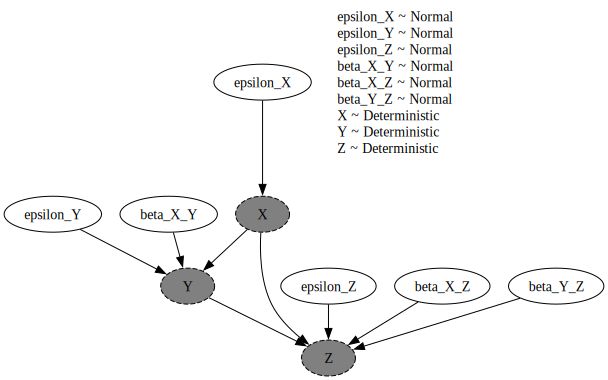

In [13]:
def compile_lscm_to_pyro(DAG: nx.DiGraph) -> nx.DiGraph:
    """
    Compiles a Linear Structural Causal Model (LSCM) represented as a directed acyclic graph (DAG) into a Pyro model.
    Parameters:
    DAG (nx.DiGraph): A directed acyclic graph where nodes represent variables and edges represent causal relationships.
                      Each node should have an 'expression' attribute containing a sympy expression for the variable.
    Returns:
    nx.DiGraph: The input DAG with additional attributes for each node:
                - 'pyro_deterministic': The deterministic Pyro value for the node, computed based on the LSCM.
    """
    symbols = list(DAG.nodes)
    expressions = nx.get_node_attributes(DAG, 'expression')
    
    sympy_modules = {symbol: SymPyModule(expressions=[expressions[symbol]]) for symbol in symbols}
    
    epsilon_samples = {symbol: pyro.sample(f'epsilon_{symbol}', dist.Normal(0, 1)) for symbol in symbols}
    beta_samples = {}
    for parent, child in DAG.edges:
        beta_samples[(parent, child)] = pyro.sample(f'beta_{parent}_{child}', dist.Normal(0, 1))
        DAG.edges[parent, child]['beta'] = beta_samples[(parent, child)]
    
    pyro_deterministic_values = {}
    for symbol in symbols:
        input_params = {f'epsilon_{symbol}': epsilon_samples[symbol]}
        for parent in DAG.predecessors(symbol):
            input_params[parent.name] = pyro_deterministic_values[parent]
            input_params[f'beta_{parent}_{symbol}'] = DAG.edges[parent, symbol]['beta']
        pyro_deterministic_values[symbol] = pyro.deterministic(symbol.name, sympy_modules[symbol](**input_params))
    
    for symbol in symbols:
        DAG.nodes[symbol]['pyro_deterministic'] = pyro_deterministic_values[symbol]
    
    return DAG

# Define the symbols and expressions
X, Y, Z = sp.symbols('X Y Z')
beta_XY, beta_YZ, beta_XZ = sp.symbols('beta_X_Y beta_Y_Z beta_X_Z')
epsilon_X, epsilon_Y, epsilon_Z = sp.symbols('epsilon_X epsilon_Y epsilon_Z')

# Create the DAG
G = nx.DiGraph()
G.add_node(X, expression=epsilon_X)
G.add_node(Y, expression=beta_XY * X + epsilon_Y)
G.add_node(Z, expression=beta_YZ * Y + epsilon_Z + beta_XZ * X + epsilon_Z)
G.add_edges_from([(X, Y), (Y, Z), (X, Z)])

# Compile the LSCM to Pyro
DAG_with_deterministic = compile_lscm_to_pyro(G)


# Visualize the model
pyro.render_model(compile_lscm_to_pyro, model_args=(G,), render_distributions=True, render_deterministic=True, filename="LSCM_graph.png")


In [ ]:
#